In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Optional

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.metrics import classification_report, log_loss

import warnings
warnings.filterwarnings('ignore')


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Download datasets
titanic = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/titanic.csv')

# Data manipulation
titanic.fillna(titanic['Age'].mean(), inplace=True)
titanic.replace({'Sex':{'male':0, 'female':1}}, inplace=True)
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch'] + 1
titanic.drop(columns=['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], inplace=True)
# titanic.head()

X = titanic[['Pclass', 'Sex', 'Age', 'FamilySize']].values
y = titanic[['Survived']].values
y[y == 0] = -1    # y must be {+1, -1}
y = y.ravel()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=102)

print('Training set:', X_train.shape, y_train.shape)
print('Val set:', X_val.shape, y_val.shape)

Training set: (712, 4) (712,)
Val set: (179, 4) (179,)


In [20]:
def check(y):
    assert set(np.unique(y)) == {-1,1}
    return y

def init_model(iters, X):
    n = X.shape[0]
    sample_weights = np.zeros((iters, n))
    stumps = np.zeros(iters, dtype= object)
    stump_weights = np.zeros(iters)
    errors = np.zeros(iters)
    return stumps, stump_weights, sample_weights, errors

def AdaBoostClf(X, y, iters= 10):
    n = X.shape[0]
    # Check y
    y = check(y)
    # Initialize
    stumps, stump_weights, sample_weights, errors = init_model(iters= iters, X= X)

    # First weight = 1/n
    sample_weights[0] = np.ones(shape= n) / n

    for i in range(iters):
        # Fit for stump: weak learner
        current_sew = sample_weights[i]
        stump = DecisionTreeClassifier(max_depth= 1, max_leaf_nodes= 2)
        stump = stump.fit(X, y, sample_weight= current_sew)

        # Calculate error
        stump_pred = stump.predict(X)
        error = current_sew[stump_pred != y].sum()
        stump_weight = np.log((1 - error) / error) / 2

        # New sample weight
        new_sew = current_sew * np.exp(-1 * stump_weight * y * stump_pred)

        # Renormalize weights
        new_sew = new_sew / new_sew.sum()

        # If not last iter, update sample weights for i+1
        if (i + 1) < iters:
            sample_weights[i+1] = new_sew

        # Save result
        errors[i] = error
        stumps[i] = stump
        stump_weights[i] = stump_weight

    return stumps, stump_weights, sample_weights

def predict(X, stumps, stump_weights):
    stump_preds = np.array([stump.predict(X) for stump in stumps])
    return np.sign(np.dot(stump_weights, stump_preds))

def plot_adaboost(X: np.ndarray,
                  y: np.ndarray,
                  stumps= None, stump_weights= None, roll = 0,
                  clf= None,
                  sample_weights: Optional[np.ndarray] = None,
                  ax: Optional[mpl.axes.Axes] = None,
                  two_features_X = [0,1],):

    y = check(y) # Kì vọng nhãn bằng ±1
    X = X[:,two_features_X]
    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
        fig.set_facecolor('white')

    pad = 1
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    if sample_weights is not None:
        sizes = np.array(sample_weights) * X.shape[0] * 100  
    else:
        sizes = np.ones(shape=X.shape[0]) * 100

    X_pos = X[y==1]
    sizes_pos = sizes[y == 1]
    ax.scatter(*X_pos.T, s=sizes_pos, marker='+', color='red')

    X_neg = X[y == -1]
    sizes_neg = sizes[y == -1]
    ax.scatter(*X_neg.T, s=sizes_neg, marker='.', c='blue')

    if clf:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['r']
        else:
            fill_colors = ['b', 'r']

        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)

    if roll:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = predict(np.c_[xx.ravel(), yy.ravel()], stumps, stump_weights)
        Z = Z.reshape(xx.shape)

        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['r']
        else:
            fill_colors = ['b', 'r']

        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)

    ax.set_xlim(x_min+0.5, x_max-0.5)
    ax.set_ylim(y_min+0.5, y_max-0.5)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')



Make datasets

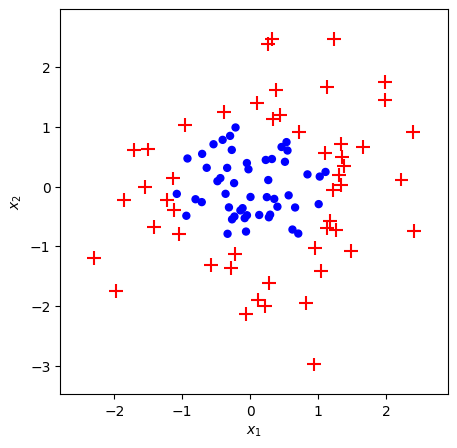

In [21]:
from sklearn.datasets import make_gaussian_quantiles
def make_dataset(n: int = 100, random_seed: int = None):
    n_per_class = int(n/2)
    if random_seed:
        np.random.seed(random_seed)
    X, y = make_gaussian_quantiles(n_samples=n, n_features=2, n_classes=2)
    return X, y*2-1

X, y = make_dataset(n=100, random_seed=10)

plot_adaboost(X,y)


Train error: 2.0%


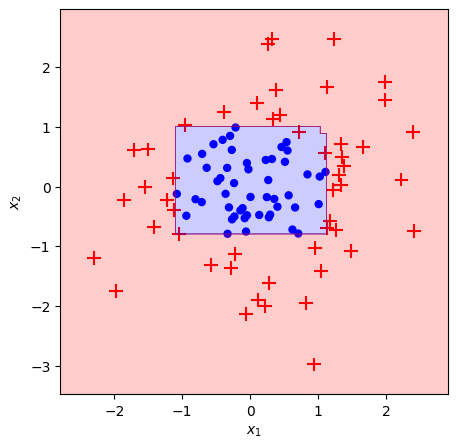

In [22]:
clf = AdaBoostClassifier(n_estimators=15, algorithm='SAMME').fit(X, y)
plot_adaboost(X, y, clf=clf)

train_err = (clf.predict(X) != y).mean()
print(f'Train error: {train_err:.1%}')


Accuracy score: 0.980000
Confusion Matrix:
[[50  0]
 [ 2 48]]
              precision    recall  f1-score   support

          -1       0.96      1.00      0.98        50
           1       1.00      0.96      0.98        50

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

Log loss: 0.006907755278982145


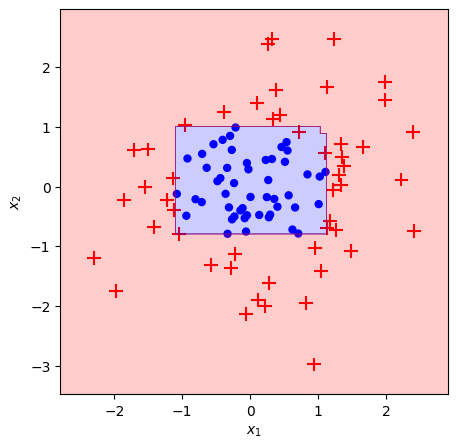

In [23]:
# Train with datasets
stumps, stump_weights, sample_weights = AdaBoostClf(X, y, iters= 15)
pred = predict(X, stumps, stump_weights)
# Show metrics
print("Accuracy score: %f" % accuracy_score(y, pred))
print("Confusion Matrix:")
print(confusion_matrix(y, pred))
print(classification_report(y, pred))
print('Log loss:', log_loss(y, pred)/len(y))
plot_adaboost(X, y, stumps, stump_weights, roll= 1)

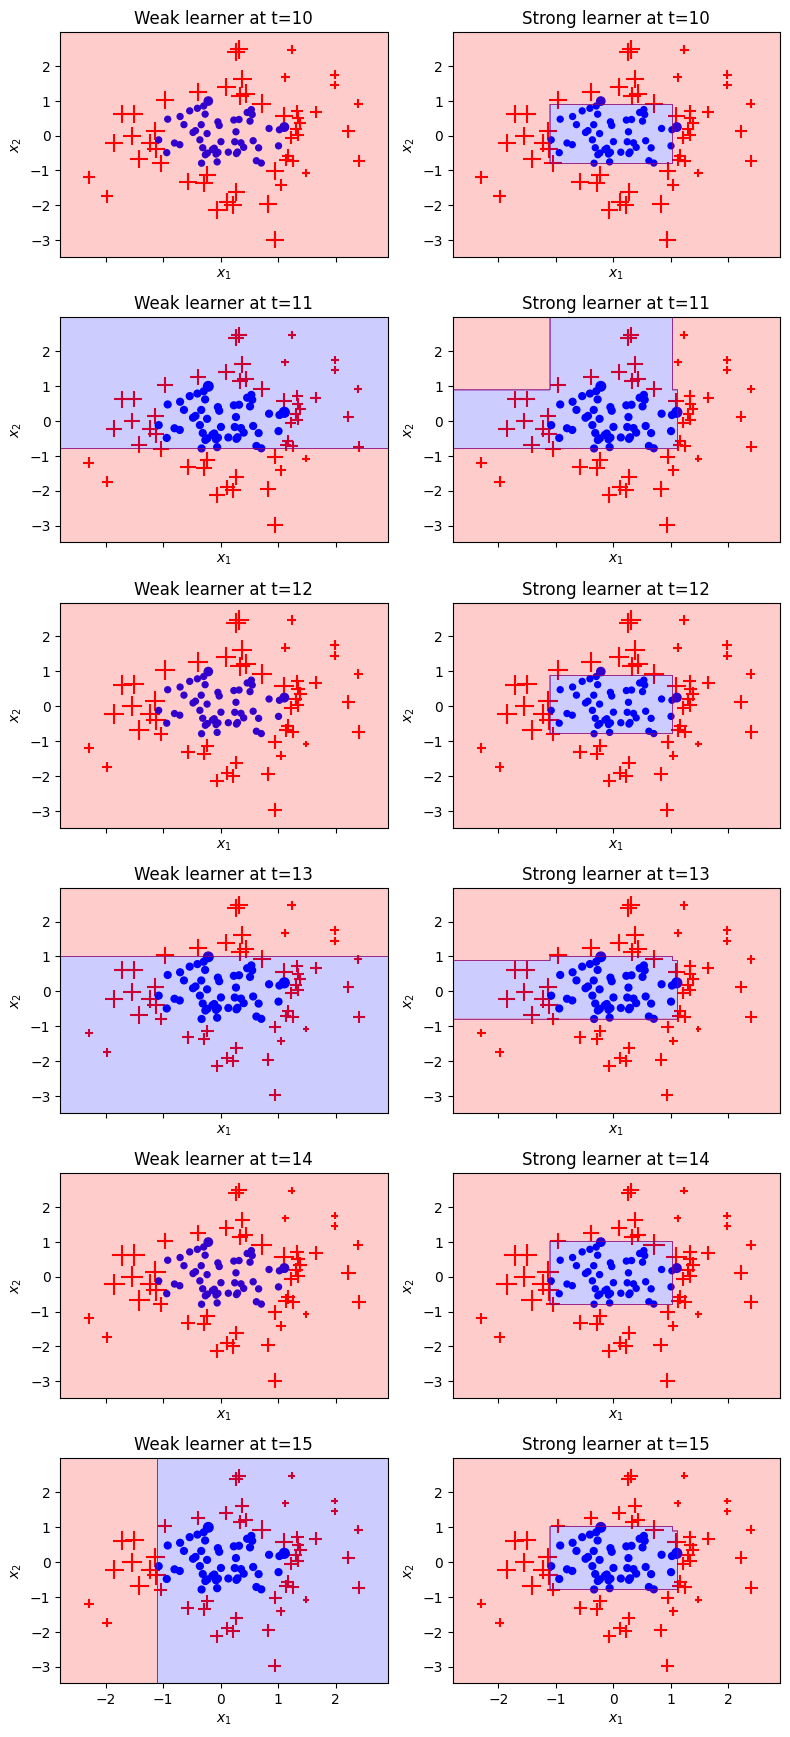

In [25]:
def truncate_adaboost(stumps, stump_weights, t: int):
    assert t > 0, 't must be a positive integer'
    x = stumps[:t]
    y = stump_weights[:t]
    return x, y

def plot_staged_adaboost(X, y, stumps, sample_weights, stump_weights, start=0, end=10):
    # larger grid
    fig, axes = plt.subplots(figsize=(8, (end-start)*3),
                             nrows=(end-start),
                             ncols=2,
                             sharex=True,
                             dpi=100)

    fig.set_facecolor('white')
    for i in range(start, end):
        ax1, ax2 = axes[i-start]

        # Plot weak learner
        ehe = ax1.set_title(f'Weak learner at t={i + 1}')
        plot_adaboost(X, y, clf= stumps[i],
                      sample_weights= sample_weights[i],
                       ax=ax1)

        # Plot strong learner
        new_stumps,  new_sw = truncate_adaboost(stumps, stump_weights, t=i + 1)
        ehe = ax2.set_title(f'Strong learner at t={i + 1}')
        plot_adaboost(X, y, new_stumps, new_sw, sample_weights= sample_weights[i], roll=1, ax=ax2)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

plot_staged_adaboost(X, y, stumps, sample_weights, stump_weights, start=9, end=15)

Có thể thấy, tại một số thời điểm (vd: t=11, 13, 15), các điểm được phân loại toàn bộ vào (+), tại sao vậy? Đơn giản là vì với tổng trọng số mẫu hiện tại, cách tốt nhất để tối thiểu hóa trọng số là phân loại tất cả các điểm là (+). Có nghĩa là, vì các mẫu (-) được bao quanh bởi các mẫu (+) có trọng số lớn, nên với 1 cây Decision Tree đơn giản, không thể classify tập dữ liệu bằng 1 đường thẳng phân tách mà làm không làm tăng trọng lượng trong số các diểm (+) bị phân loại sai, điều đó thật tệ với thuật toán, vì khi phân loại tất cả các điểm thành (+), các điểm (-) bị phân loại sai làm tăng trọng số các điểm (-), hay tăng tổng trọng số các điểm lên. Tuy nhiên, điều đó không đủ để ngăn thuật toán hội tụ, với việc cây thứ t phân loại sai làm tăng trọng số các mẫu (-), sẽ giúp cho cây t+1, tìm được 1 đường phân tách mang tính tích cực và quyết định hơn cho thuật toán